In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of data points
num_samples = 500

# Generate random data for features
x = np.linspace(0, 10, num_samples)
pH = 7 + 1.5 * np.sin(x) + (x / 20) * 1.5  # Smaller amplitude for pH variation
temperature = np.random.uniform(15, 35, num_samples)
x = np.linspace(0, num_samples, num_samples)
co2_concentration = 320 + 0.01*x + np.sin(300*x)    # in micro-mol/mol
salinity = np.random.uniform(34, 35.5, num_samples)
mu, sigma = 7, 1
dissolved_o2 = np.random.normal(mu, sigma, num_samples) * 32  # Convert mg/L to micro-mol/kg
mu, sigma = 15, 5
nitrate_concentration = np.random.normal(mu, sigma, num_samples)
no3_concentration = np.clip(nitrate_concentration, 0, None)
year = np.linspace(1970, 2020, num_samples)

# For demonstration, let's assume erosion occurs more frequently at lower pH levels
erosion_label = np.zeros(num_samples)
two_thirds_index = 2 * num_samples // 3
erosion_label[two_thirds_index:] = 1

# Create DataFrame
data = pd.DataFrame({
    'pH': pH,
    'temperature': temperature,
    'salinity': salinity,
    'dissolved_o2': dissolved_o2,
    'erosion_label': erosion_label,
    'co2_concentration': co2_concentration,
    'no3_concentration': nitrate_concentration,
    'year': year
})

# Save the dataset to a CSV file
data.to_csv('mollusc_erosion_dataset.csv', index=False)

# Display the first few rows of the dataset
print(data.head())

         pH  temperature   salinity  dissolved_o2  erosion_label  \
0  7.000000    22.490802  35.047243    229.686432            0.0   
1  7.031561    34.014286  34.804145    181.268981            0.0   
2  7.063110    29.639879  34.464291    236.166331            0.0   
3  7.094635    26.973170  35.220693    243.538744            0.0   
4  7.126124    18.120373  35.027097    241.913294            0.0   

   co2_concentration  no3_concentration         year  
0         320.000000          15.667705  1970.000000  
1         319.173067          14.237651  1970.100200  
2         319.103954          18.540543  1970.200401  
3         319.864313          19.783512  1970.300601  
4         320.774748          11.070053  1970.400802  


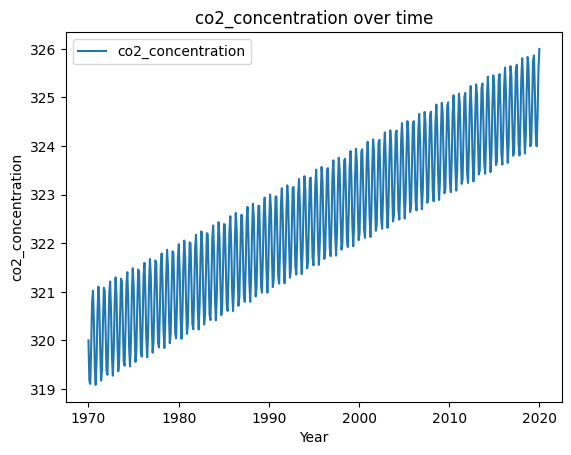

In [ ]:
# Plot co2_concentration over time
data.plot(x='year', y='co2_concentration', kind='line')
plt.title('co2_concentration over time')
plt.xlabel('Year')
plt.ylabel('co2_concentration')
plt.show()

In [ ]:
# Load dataset
data = pd.read_csv('mollusc_erosion_dataset.csv')

# Split features and target
X = data.drop('erosion_label', axis=1)
y = data['erosion_label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define hyperparameters grid for tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)

# Optimize Acidity Level Prediction

# Define acidity levels to test
acidity_levels = np.random.uniform(0, 14, 5)

# Predict erosion likelihood for each acidity level
erosion_likelihoods = []
temp = 28  # degree C
sal = 34  # ppt
dissolved_o2 = 8  # mg/L
co2_concentration = data['co2_concentration'].mean()  # Mean value from the dataset
nitrate_concentration = data['no3_concentration'].mean()  # Mean value from the dataset
year = data['year'].mean()  # Mean value from the dataset

for acidity in acidity_levels:
    new_data = pd.DataFrame({'pH': [acidity], 'temperature': [temp], 'salinity': [sal],
                             'dissolved_o2': [dissolved_o2], 'co2_concentration': [co2_concentration],
                             'no3_concentration': [nitrate_concentration], 'year': [year]})
    erosion_likelihood = best_rf_model.predict_proba(new_data)[:, 1]
    erosion_likelihoods.append(erosion_likelihood)

# Find the acidity level with the lowest erosion likelihood
optimum_acidity_level = acidity_levels[np.argmin(erosion_likelihoods)]
print("Optimum Acidity Level:", optimum_acidity_level)

Best Model Accuracy: 0.98
Optimum Acidity Level: 4.638858099442711


In [ ]:
# 3D Scatter plot
fig = px.scatter_3d(data, x='pH', y='temperature', z='erosion_label', color='erosion_label')
fig.show()

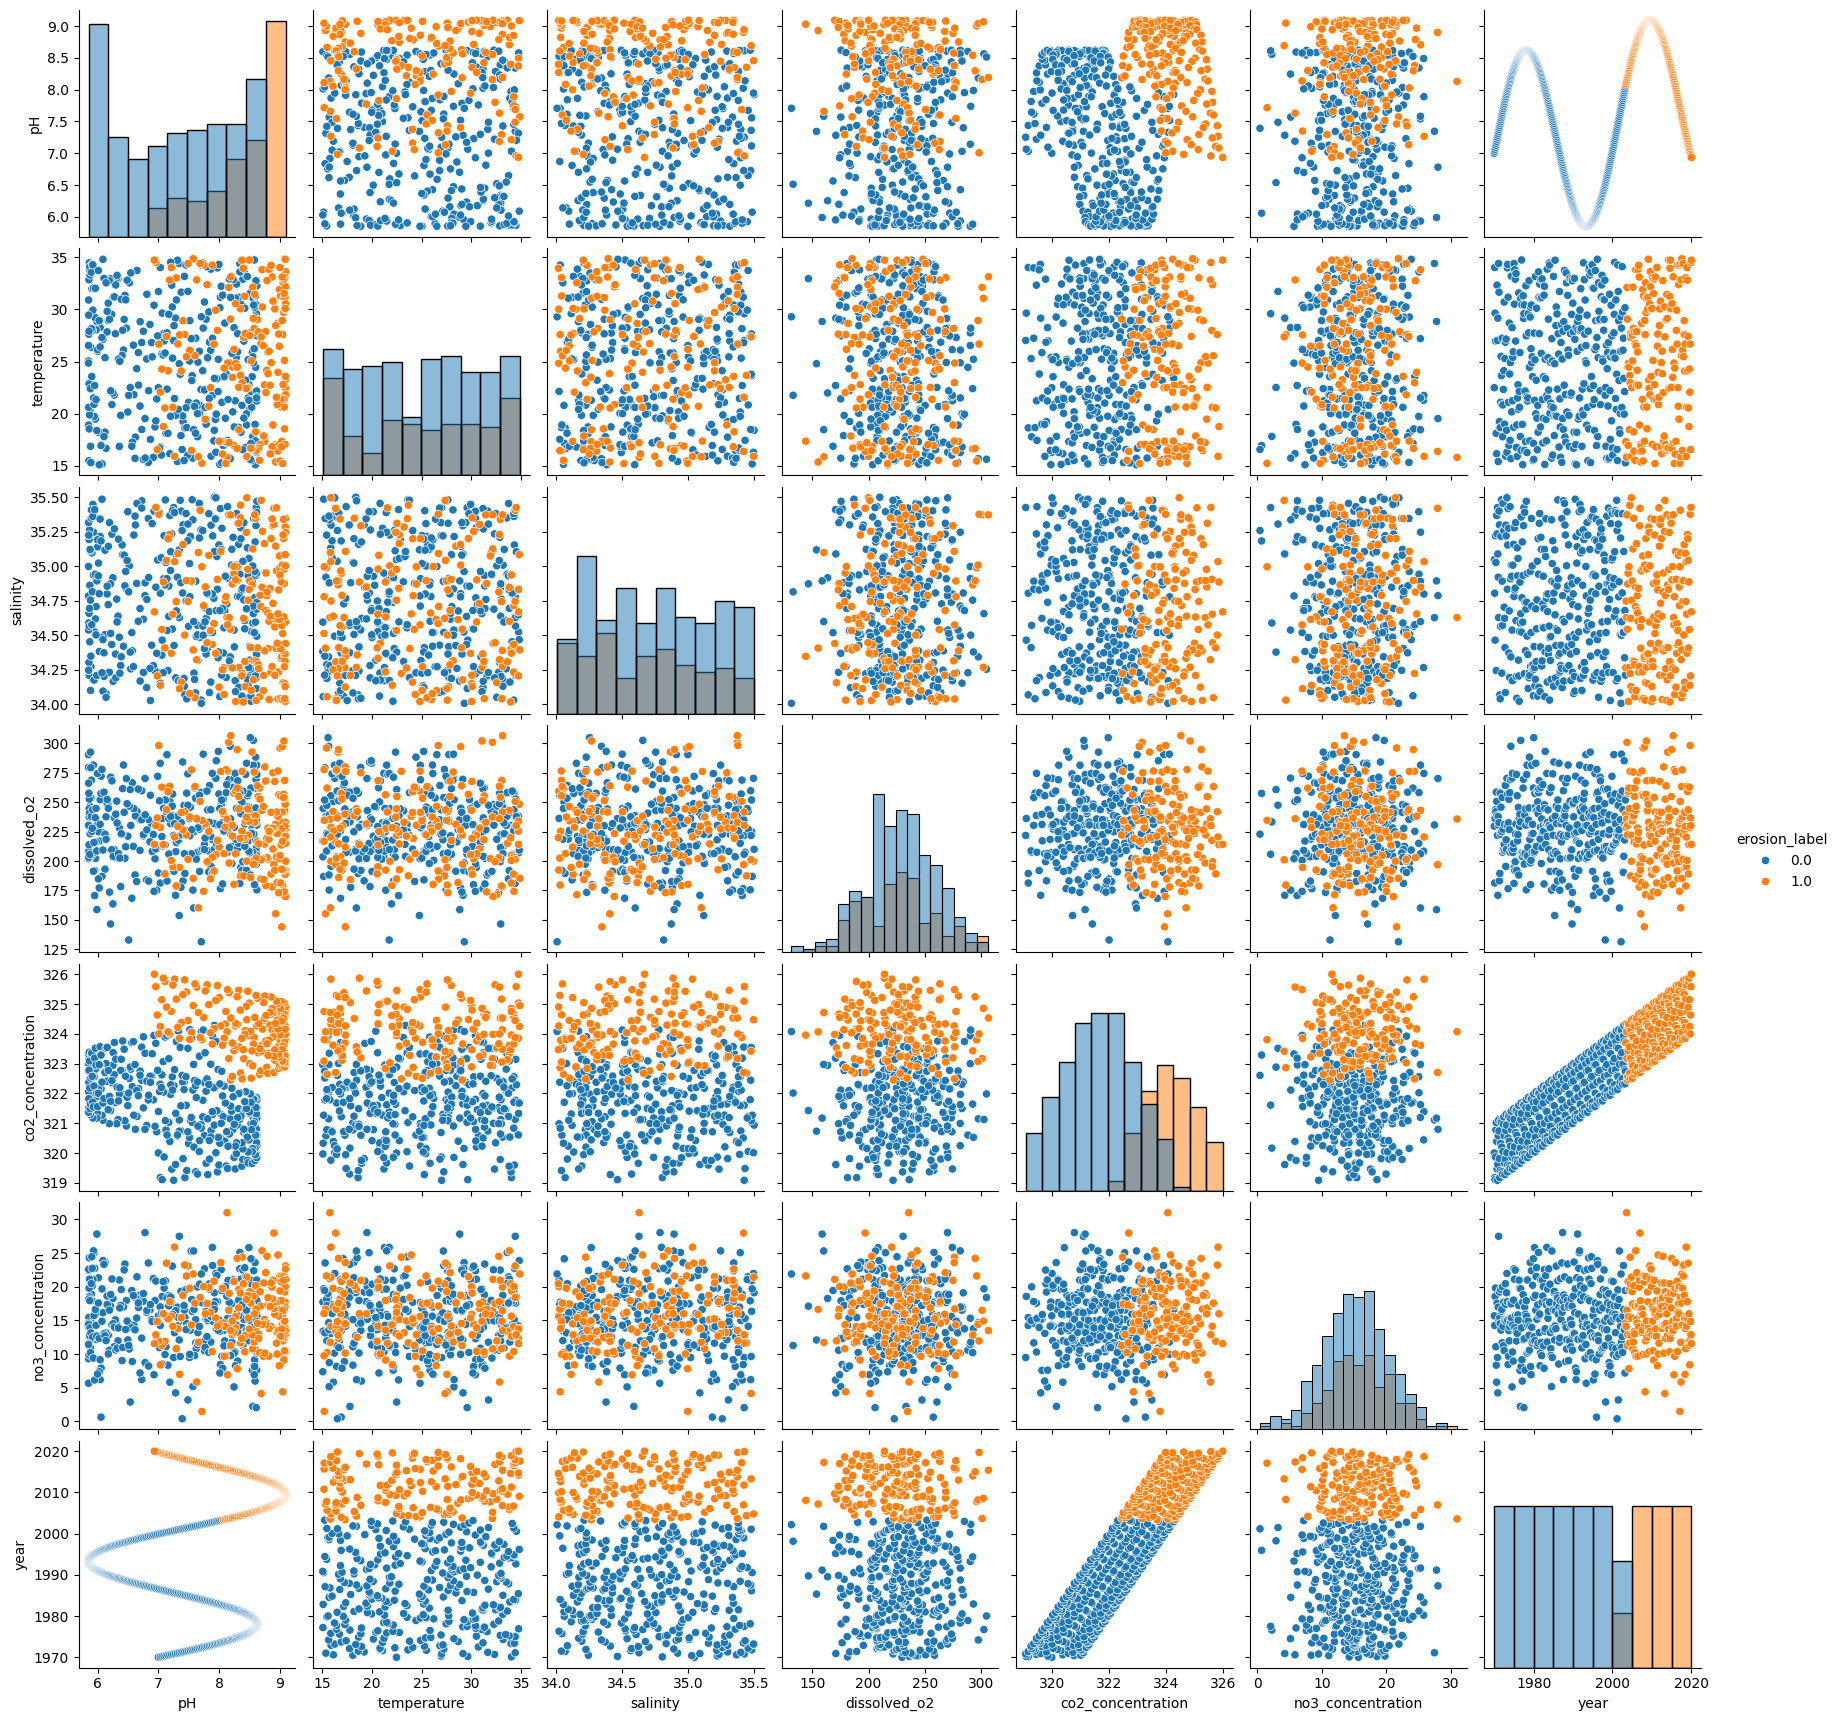

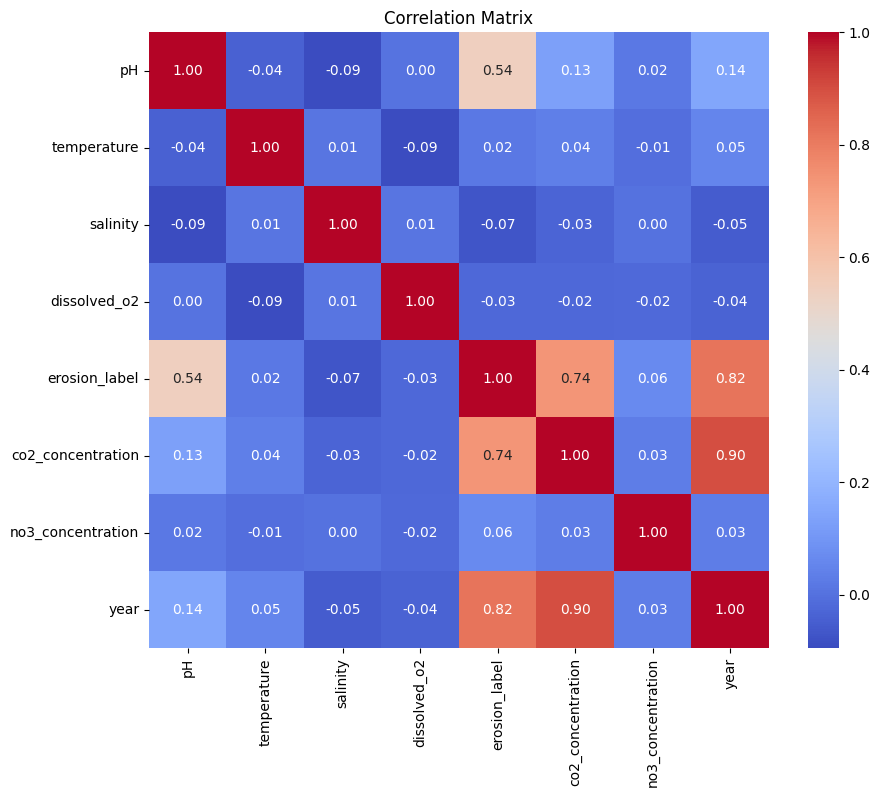

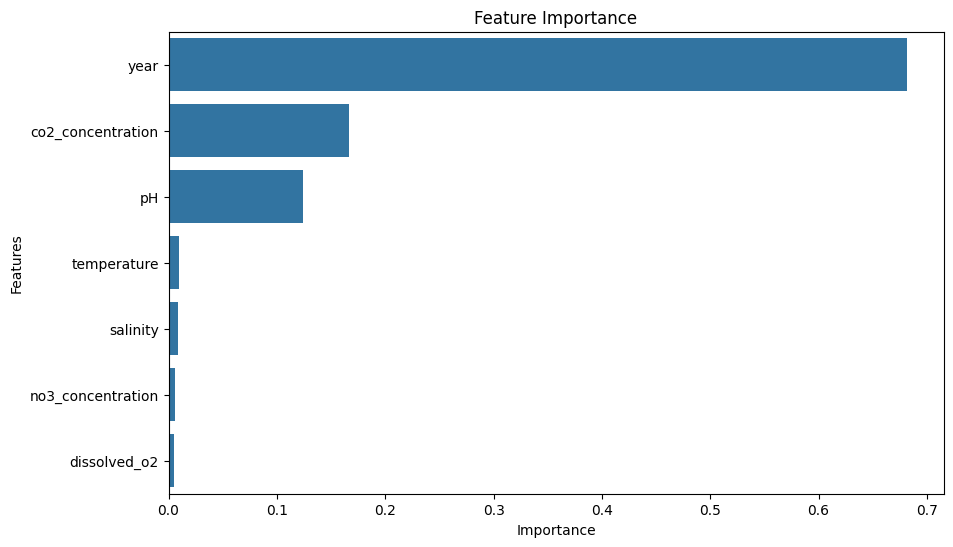

In [ ]:
# 1. Data Visualization
sns.pairplot(data, hue='erosion_label', diag_kind='hist')
plt.show()

# 2. Correlation Analysis
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# 3. Feature Importance
feature_importances = best_rf_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
feature_names = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[sorted_indices], y=feature_names[sorted_indices])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# 4. Predicting Erosion Likelihood under Different Conditions
# Define conditions for prediction
acidity_levels = np.linspace(6.0, 8.5, 50)
temperature = 28  # degree C
salinity = 34  # ppt
dissolved_o2 = 8  # mg/L
co2_concentration = data['co2_concentration'].mean()  # Mean value from the dataset
nitrate_concentration = data['no3_concentration'].mean()  # Mean value from the dataset
year = data['year'].mean()  # Mean value from the dataset

# Predict erosion likelihood for each acidity level
erosion_likelihoods = []
for acidity in acidity_levels:
    new_data = pd.DataFrame({'pH': [acidity], 'temperature': [temperature], 'salinity': [salinity],
                             'dissolved_o2': [dissolved_o2], 'co2_concentration': [co2_concentration],
                             'no3_concentration': [nitrate_concentration], 'year': [year]})
    erosion_likelihood = best_rf_model.predict_proba(new_data)[:, 1]
    erosion_likelihoods.append(erosion_likelihood)
